## <b>1. Key Points<b>

* In ARIMA, time series data is a scalar/array. In the case of VAR and VARMA, they become vectors. And the products of vectors are matrices, thus the coefficients are now matrices.
* Also remember that this model is still linear regression.

* Number of parameters:
1. Scalar case (AR): if we have D independent time series and p corresponding AR orders (the number of lags), then in total we will have D(p + 1) parameters. This is because each independent time series will have (p + 1) parameters including the intercept.
2. Vector case (VAR): the number of parameters for the similar situation is pD^2 + D. So as D grows, the number of parameters grow faster (quadratically). Thus, we need to consider carefully to avoid over-fitting.

* Among the model selection criteria, AIC tends to pick models with large number of lags. In the case of VAR, we therefore prefer to use BIC to choose between models because it penalizes more for over-complicated models (too many parameters).
  
* Why ARIMA models are more popular than VARMA models? => VARMA models are not unique (can’t determine unique p, q).
  
* Why there is no VARIMA? => we only want to use VARMA, ARMA if the time series is stationary (it’s their assumptions). Data points in different time series may need to be differenced with different orders, i.e. there isn’t one unique value for d. There has been no pre-develop libraries handle this, and we need to ensure stationarity before running the model.
  
* Data normalization among time series of different scales: as long as we split the data set into the train and test set before normalizing them, then it is fine (to avoid data leakage).

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.api import VAR, VARMAX
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## <b>2. Define supplementary functions<b>

### 2.1. Function to check Stationarity

In [6]:
# CHECK STATIONARITY

def check_stationarity(data: pd.DataFrame) -> pd.DataFrame:
    def _run_tests(series):
        """Runs the ADF and KPSS tests on a single series."""
        result = {}
        series = series.dropna()  # Remove missing values
        
        # ADF test for stationarity (null hypothesis: series has a unit root, i.e., non-stationary)
        adf_test = adfuller(series)
        adf_pvalue = adf_test[1]
        result['ADF Test'] = "Stationary" if adf_pvalue < 0.05 else "Non-Stationary"

        # KPSS test for stationarity (null hypothesis: series is stationary)
        kpss_test = kpss(series, regression='ct')  # 'ct' for constant and trend
        kpss_pvalue = kpss_test[1]
        result['KPSS Test (Trend)'] = "Non-Stationary" if kpss_pvalue < 0.05 else "Stationary"
        
        # KPSS test for constant (non-zero mean)
        kpss_const_test = kpss(series, regression='c')  # 'c' for constant only
        kpss_const_pvalue = kpss_const_test[1]
        result['KPSS Test (Constant)'] = "Non-Stationary" if kpss_const_pvalue < 0.05 else "Stationary"

        return result

    # If the input is a pandas Series (single time series)
    if isinstance(data, pd.Series):
        data = data.to_frame()

    # Run the tests for each column in the DataFrame
    results = {}
    for column in data.columns:
        results[column] = _run_tests(data[column])

    # Convert the results dictionary into a DataFrame
    results_df = pd.DataFrame(results).T
    results_df.index.name = "Series"
    
    return results_df

### 2.2. Function to check the Integration order (I)
* <b>One important requirement of VAR and VARMA models is that the series need to be stationary (hence there is no 'I' in their names).<b>

In [8]:
def difference_until_pass_kpss(data: pd.DataFrame, max_diff=3, significance_level=0.05):
    """
    Perform differencing on the time series until it passes the KPSS test for stationarity
    or until the maximum number of differencing steps (max_diff) is reached.

    Parameters:
    - data: The original time series (pandas Series or DataFrame).
    - max_diff: The maximum number of differencing steps to apply.
    - significance_level: The significance level for the KPSS test (default is 0.05).

    Prints:
    - A message indicating whether the series became stationary or failed the KPSS test.
    """

    def kpss_test(ts):
        """Run KPSS test on the time series and return whether it passes the test (stationary)."""
        statistic, p_value, _, _ = kpss(ts, regression='c', nlags="auto")
        return p_value > significance_level  # If p-value is greater than significance level, the series is stationary

    def process_single_series(time_series, col_name):
        """Handle differencing for a single series."""
        d = 0  # Initialize differencing count
        diff_series = time_series.copy()

        # Loop to difference and test for stationarity using KPSS
        while d <= max_diff:
            if kpss_test(diff_series):
                print(f"'{col_name}' became stationary after {d} differencing(s).")
                return d  # Return the number of differencing steps taken to achieve stationarity
            else:
                d += 1
                if d <= max_diff:
                    diff_series = diff_series.diff().dropna()  # Apply differencing

        # If the loop ends without the series becoming stationary
        print(f"'{col_name}' failed the KPSS test after {max_diff} differencing(s).")
        return None  # Return None if the series does not become stationary

    # If the input is a pandas Series (single time series)
    if isinstance(data, pd.Series):
        process_single_series(data, data.name)

    # If the input is a pandas DataFrame (multiple time series)
    elif isinstance(data, pd.DataFrame):
        for column in data.columns:
            print(f"Processing '{column}':")
            process_single_series(data[column], column)
            print("\n" + "="*50 + "\n")  # Separator for readability between columns

    else:
        raise ValueError("Input must be a pandas Series or DataFrame.")

### 2.3. Plot ACF and PACF to skim for a reasonable VAR, VARMA orders

In [10]:
def plot_acf_pacf(data, lags=40):
    """
    Plots the ACF and PACF for each time series in the DataFrame or Series.
    
    Args:
        data: A pandas Series or DataFrame containing the time series data.
        lags: Number of lags to include in the ACF/PACF plots (default is 40).
    
    Returns:
        A figure with subplots showing the ACF and PACF for each series.
    """
    
    # If the input is a Series, convert it to a DataFrame for consistency
    if isinstance(data, pd.Series):
        data = data.to_frame()

    # Number of time series (columns) in the DataFrame
    n_series = data.shape[1]

    # Create a figure with subplots. Each row will have 2 subplots (ACF and PACF)
    fig, axes = plt.subplots(n_series, 2, figsize=(12, 4 * n_series))

    # If there is only one series, adjust the axes
    if n_series == 1:
        axes = [axes]

    # Iterate through each time series and plot the ACF and PACF
    for i, column in enumerate(data.columns):
        # Plot ACF on the left
        plot_acf(data[column].dropna(), lags=lags, ax=axes[i][0])
        axes[i][0].set_title(f'ACF of {column}')

        # Plot PACF on the right
        plot_pacf(data[column].dropna(), lags=lags, ax=axes[i][1])
        axes[i][1].set_title(f'PACF of {column}')
    
    plt.tight_layout()
    return fig

### 2.4. Evaluation models with metrics
* Because for VAR or VARMA models, each series is an endogenous variable, hence we need to calculate the metrics for each of them after forecasting.
* Moreover, we should incorporate the reversion of log transformation in case that our data was log transformed before fitting.

In [12]:
def evaluate_varma(y_true, y_pred, logged_cols=None):
    """
    Calculate common evaluation metrics for both univariate and multivariate models, 
    handling cases where some series are log-transformed and others are not, and return a DataFrame.
    
    Args:
        y_true: A pandas DataFrame or a 1D/2D array of actual values.
        y_pred: A pandas DataFrame or a 1D/2D array of predicted values.
        logged_cols: List of column names (for DataFrame) or indices (for arrays) that are log-transformed.
                     If evaluating a single series, pass a boolean indicating if the series is logged.
    
    Returns:
        A pandas DataFrame with evaluation metrics (MAE, MSE, RMSE, MAPE, R²) as columns.
        For multivariate models, the index will be the variable names.
    """
    metrics = {}
    
    # Check if it's a univariate case (1D array or a pandas Series)
    if isinstance(y_true, (pd.Series, np.ndarray)) and y_true.ndim == 1:
        # If logged_cols is a boolean and True, apply exp transformation
        if isinstance(logged_cols, bool) and logged_cols:
            y_true = np.exp(y_true)
            y_pred = np.exp(y_pred)
        
        # Calculate metrics for the single series
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.inf
        r2 = r2_score(y_true, y_pred)
        
        metrics = {
            'MAE': round(mae, 6),
            'MSE': round(mse, 6),
            'RMSE': round(rmse, 6),
            'MAPE': round(mape, 6) if not np.isinf(mape) else np.nan,
            'R²': round(r2, 6)
        }
        
        # Convert the result to a DataFrame with a single row
        return pd.DataFrame([metrics], index=['Univariate'])

    else:
        # If logged_cols is None, assume no logging; otherwise, handle list of log-transformed columns
        logged_cols = logged_cols if logged_cols is not None else []
        
        # Convert to DataFrame if numpy array is provided
        if isinstance(y_true, np.ndarray):
            y_true = pd.DataFrame(y_true)
        if isinstance(y_pred, np.ndarray):
            y_pred = pd.DataFrame(y_pred)
        
        # Loop through each variable (column) and calculate metrics individually
        for col in y_true.columns:
            actual = y_true[col]
            predicted = y_pred[col]
            
            # If the column is logged, revert it back to the original scale
            if col in logged_cols:
                actual = np.exp(actual)
                predicted = np.exp(predicted)
            
            # Calculate evaluation metrics
            mae = mean_absolute_error(actual, predicted)
            mse = mean_squared_error(actual, predicted)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual - predicted) / actual)) * 100 if np.all(actual != 0) else np.inf
            r2 = r2_score(actual, predicted)
            
            # Store metrics for the current variable
            metrics[col] = {
                'MAE': round(mae, 6),
                'MSE': round(mse, 6),
                'RMSE': round(rmse, 6),
                'MAPE': round(mape, 6) if not np.isinf(mape) else np.nan,  # Handle division by zero in MAPE
                'R²': round(r2, 6)
            }
    
        # Convert the dictionary to a DataFrame
        metrics_df = pd.DataFrame(metrics).T  # Transpose to have variables as rows
        return metrics_df

## <b>3. VARMA<b>

### 3.1. Defining the function for our VARMA models

* The workflow of the function:
1. Set the input parameters dynamically, including the orders
2. Set the frequency for the time series data
3. Split the dataset into training and testing sets (after differencing)
4. Normalization if needed
5. Fit the VARMA model on the differenced and scaled training data
6. Forecast the test data
7. Revert scaling if needed
8. Plot the graph if needed
9. Return trained and forecasted data to calculate performance metrics later
10. Run post model diagnostics

In [15]:
def varma_split(df, cols, freq='QS', Ntest=12, order=(18, 1), maxiter=100, 
                use_scaling=False, plot=True, summary=True, diagnostic=True):
    """
    Dynamic VARMA modeling for any time series dataset with optional scaling, summary, diagnostics, and plotting.
    
    Parameters:
    df: pandas.DataFrame - The input DataFrame with time series data.
    cols: list - List of column names to use in the VARMA model.
    freq: str - Frequency of the time series data ('QS' for Quarterly Start by default).
    Ntest: int - Number of test samples for forecasting.
    order: tuple - Order of the VARMA model (p, q).
    maxiter: int - Maximum number of iterations for model fitting.
    use_scaling: bool - Whether to scale the data (default is False).
    plot: bool - Whether to plot the actual and predicted values (default is True).
    summary: bool - Whether to print the summary of the fitted model (default is True).
    diagnostic: bool - Whether to perform and print diagnostics like residual analysis (default is True).
    
    Returns:
    actual_train: The actual values for the training period (for all columns).
    train_prediction: The predicted values for the training period (for all columns).
    actual_test: The actual values for the testing period (for all columns).
    test_forecast: The predicted values for the testing period (for all columns).
    """
    # Set the frequency for the time series data
    df.index.freq = freq
    
    # Split the dataset into training and testing sets
    train = df.iloc[:-Ntest].copy()
    test = df.iloc[-Ntest:].copy()
    
    # Boolean indexing for train and test
    train_idx = df.index <= train.index[-1]
    test_idx = ~train_idx
    
    # Initialize scaler if scaling is enabled
    if use_scaling == True:
        scaler = StandardScaler()
        train[cols] = scaler.fit_transform(train[cols])
        test[cols] = scaler.transform(test[cols])
        
        # Put the scaled values back into the original DataFrame
        df.loc[train_idx, cols] = train[cols]
        df.loc[test_idx, cols] = test[cols]
    
    # Fit the VARMA model on the training data
    model = VARMAX(train[cols], order=order)
    res = model.fit(maxiter=maxiter)
    
    # Forecast for the next Ntest points
    fcast = res.get_forecast(Ntest)
    
    # Store the actual and predicted values for all columns
    actual_train_scaled = df.loc[train_idx, cols].values
    train_prediction_scaled = res.fittedvalues[cols].values
    actual_test_scaled = df.loc[test_idx, cols].values
    test_forecast_scaled = fcast.predicted_mean[cols].values
    
    # Reverting transformation back to the original scale if scaling was applied
    if use_scaling == True:
        actual_train = pd.DataFrame(scaler.inverse_transform(actual_train_scaled), columns=cols, index=df.loc[train_idx].index)
        train_prediction = pd.DataFrame(scaler.inverse_transform(train_prediction_scaled), columns=cols, index=df.loc[train_idx].index)
        actual_test = pd.DataFrame(scaler.inverse_transform(actual_test_scaled), columns=cols, index=df.loc[test_idx].index)
        test_forecast = pd.DataFrame(scaler.inverse_transform(test_forecast_scaled), columns=cols, index=df.loc[test_idx].index)
    else:
        actual_train = pd.DataFrame(actual_train_scaled, columns=cols, index=df.loc[train_idx].index)
        train_prediction = pd.DataFrame(train_prediction_scaled, columns=cols, index=df.loc[train_idx].index)
        actual_test = pd.DataFrame(actual_test_scaled, columns=cols, index=df.loc[test_idx].index)
        test_forecast = pd.DataFrame(test_forecast_scaled, columns=cols, index=df.loc[test_idx].index)

    # Plot actual vs predicted values for each column dynamically
    if plot:
        for col in cols:
            plt.figure(figsize=(15, 6))
        
            # Plot fitted values during the training period
            df.loc[train_idx, f'Fitted values {col}'] = res.fittedvalues[col]
            df.loc[train_idx, f'Fitted values {col}'].plot(color='green', label='Fitted values')

            # Plot forecast values only for the test period
            test_forecast_index = df.index[-Ntest:]  # Ensure forecast is indexed correctly for test period
            df.loc[test_forecast_index, f'Test forecasts {col}'] = fcast.predicted_mean[col]
            df.loc[test_forecast_index, f'Test forecasts {col}'].plot(color='blue', label='Forecast values')
    
            # Plot actual data for the entire period
            df[col].plot(color='orange', label='Actual data', alpha=0.5)
    
            plt.title(f"{col}: VARMA{order}", color='darkred')
            plt.grid(True, alpha=0.3)
            plt.legend(loc='upper left')
            plt.show()

    # Print summary if required
    if summary:
        print(res.summary())
    
    # Diagnostic plots and tests
    if diagnostic:
        residuals = res.resid
        
        # Residual plots
        residuals.plot(subplots=True, title='Residuals')
        plt.show()
        
        # ACF and PACF plots for residuals
        for i, col in enumerate(cols):
            plt.figure(figsize=(10, 4))
            plt.subplot(121)
            plot_acf(residuals[col], lags=20, ax=plt.gca())
            plt.title(f"ACF of Residuals for {col}")
            plt.subplot(122)
            plot_pacf(residuals[col], lags=20, ax=plt.gca())
            plt.title(f"PACF of Residuals for {col}")
            plt.tight_layout()
            plt.show()

    return actual_train, train_prediction, actual_test, test_forecast

### 3.2. First Dataset

In [17]:
df_1 = pd.read_csv('temperature.csv')
df_1.head(3)

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [18]:
# A little manipulation to get a nice time format
from datetime import datetime

def parse_date(row):
  s = f"{row['year']}-{row['month']}-{row['day']}"
  return datetime.strptime(s, "%Y-%m-%d")

In [19]:
# Just some data manipulations

df_1['Date'] = df_1.apply(parse_date, axis=1)

auckland = df_1[df_1['City'] == 'Auckland'].copy().dropna()
stockholm = df_1[df_1['City'] == 'Stockholm'].copy().dropna()

# keep only columns we want
auckland = auckland[['Date', 'AverageTemperatureFahr']].copy()
stockholm = stockholm[['Date', 'AverageTemperatureFahr']].copy()

# set index to date col
auckland.set_index(auckland['Date'], inplace=True)
auckland.drop('Date', axis=1, inplace=True)
auckland.columns = ['AucklandTemp']

stockholm.set_index(stockholm['Date'], inplace=True)
stockholm.drop('Date', axis=1, inplace=True)
stockholm.columns = ['StockholmTemp']

joined = auckland.join(stockholm, how='outer') # has some missing data

joined_part = joined.iloc[-500:].copy() # extract a part of the data to demonstrate the model

joined_part.interpolate(inplace=True) # interpolation of missing values

joined_part.head()

,AucklandTemp,StockholmTemp
Date,,
1972-01-01,64.7312,27.9194
1972-02-01,65.2010,31.8020
1972-03-01,67.2116,33.3140
1972-04-01,62.6378,37.1462
1972-05-01,58.4708,44.9906


In [20]:
check_stationarity(joined_part) # Check if Differencing is needed

,ADF Test,KPSS Test (Trend),KPSS Test (Constant)
Series,,,
AucklandTemp,Stationary,Stationary,Stationary
StockholmTemp,Stationary,Stationary,Stationary


* So we do not need to do Differencing for this dataset.

In [22]:
len(joined_part) # check the length to find the split data point

500

In [23]:
joined_part.isna().sum() # sanity check

AucklandTemp     0
StockholmTemp    0
dtype: int64

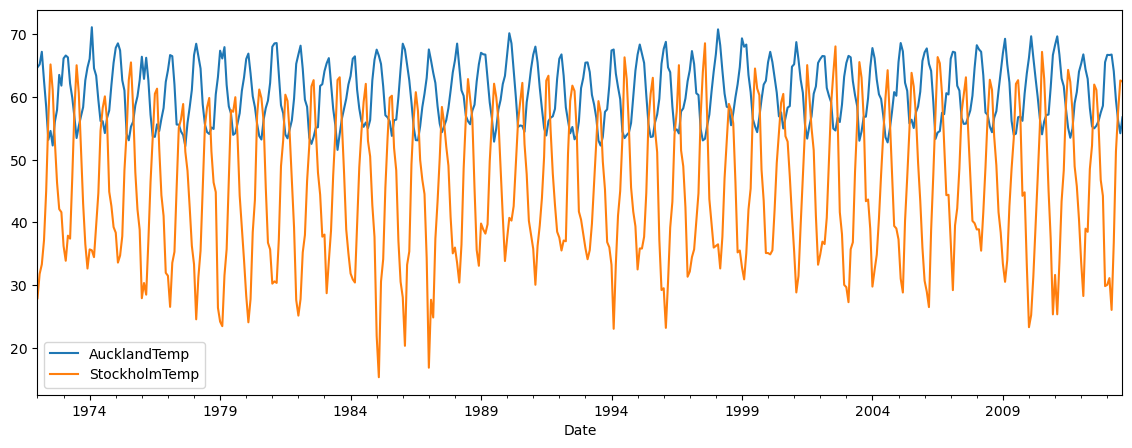

In [24]:
joined_part.plot(figsize = (14,5)); # have a look to see if we need to do normalization

In [25]:
cols_1 = ['AucklandTemp','StockholmTemp'] # make a list of series interested

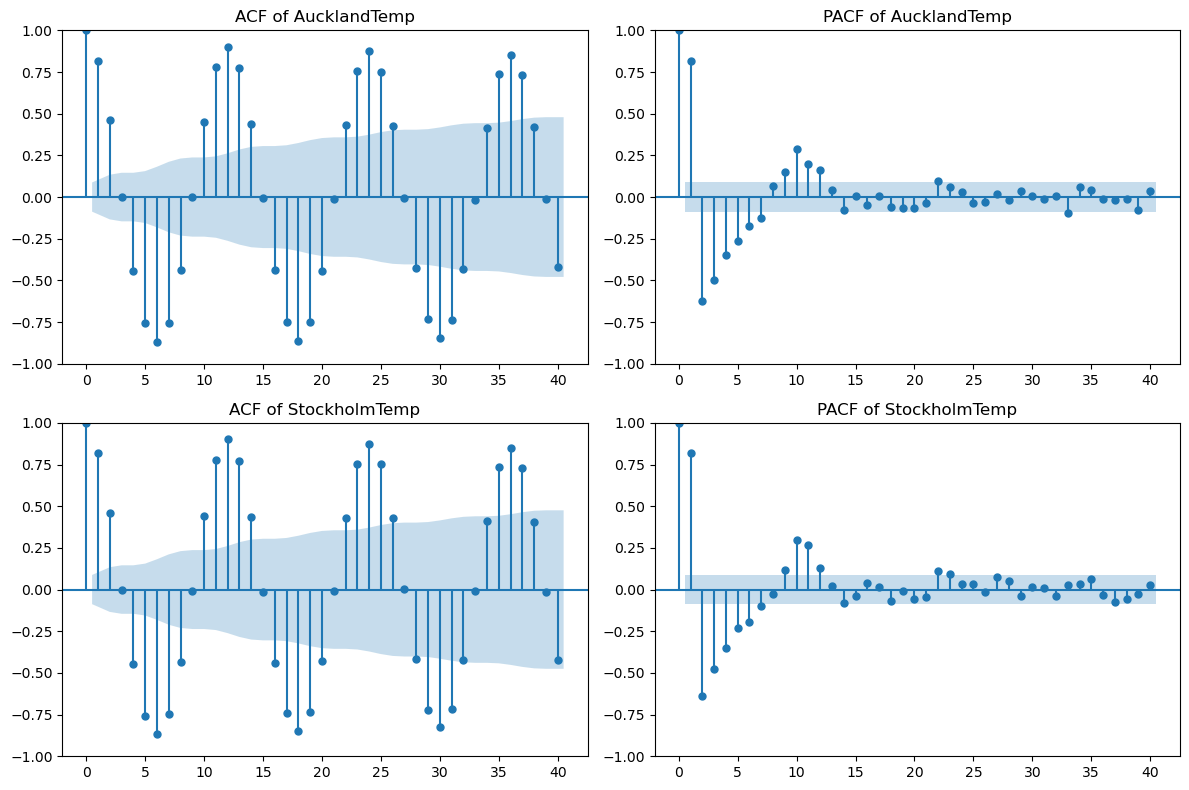

In [26]:
plot_acf_pacf(joined_part);

In [27]:
# Here I create a copy because I re-use this data for VAR model later
joined_part_a =  joined_part.copy()

In [28]:
Ntest_1 = round(500*0.25)
Ntest_1

125

In [29]:
joined_part_a.head(3)

,AucklandTemp,StockholmTemp
Date,,
1972-01-01,64.7312,27.9194
1972-02-01,65.2010,31.8020
1972-03-01,67.2116,33.3140


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           65     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03164D-01    |proj g|=  2.93179D-01


 This problem is unconstrained.



At iterate    5    f=  2.89863D-01    |proj g|=  2.86276D-01

At iterate   10    f=  2.74763D-01    |proj g|=  3.17560D-01

At iterate   15    f=  2.68153D-01    |proj g|=  1.12328D-01

At iterate   20    f=  2.59624D-01    |proj g|=  1.50469D-01

At iterate   25    f=  2.52750D-01    |proj g|=  9.15056D-02

At iterate   30    f=  2.49865D-01    |proj g|=  1.03624D-01

At iterate   35    f=  2.46933D-01    |proj g|=  1.36233D-01

At iterate   40    f=  2.42595D-01    |proj g|=  4.83828D-02

At iterate   45    f=  2.35165D-01    |proj g|=  1.46862D-01

At iterate   50    f=  2.30049D-01    |proj g|=  5.58892D-02

At iterate   55    f=  2.25576D-01    |proj g|=  8.18416D-02

At iterate   60    f=  2.22168D-01    |proj g|=  1.08762D-01

At iterate   65    f=  2.18797D-01    |proj g|=  4.41165D-02

At iterate   70    f=  2.16682D-01    |proj g|=  1.83032D-01

At iterate   75    f=  2.14827D-01    |proj g|=  1.09468D-01

At iterate   80    f=  2.12480D-01    |proj g|=  9.40291D-02

At iter

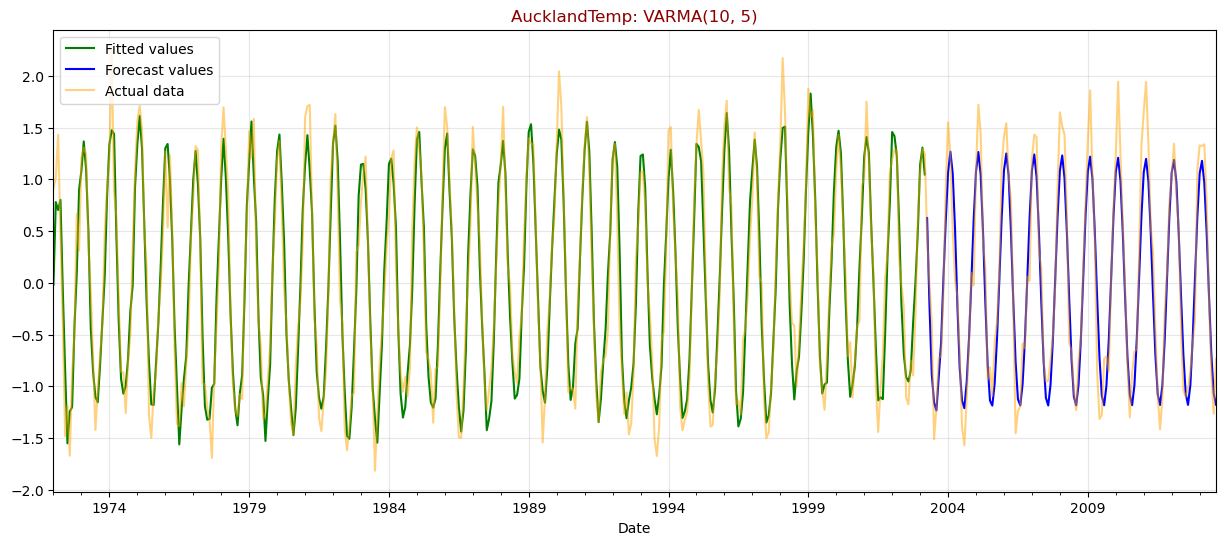

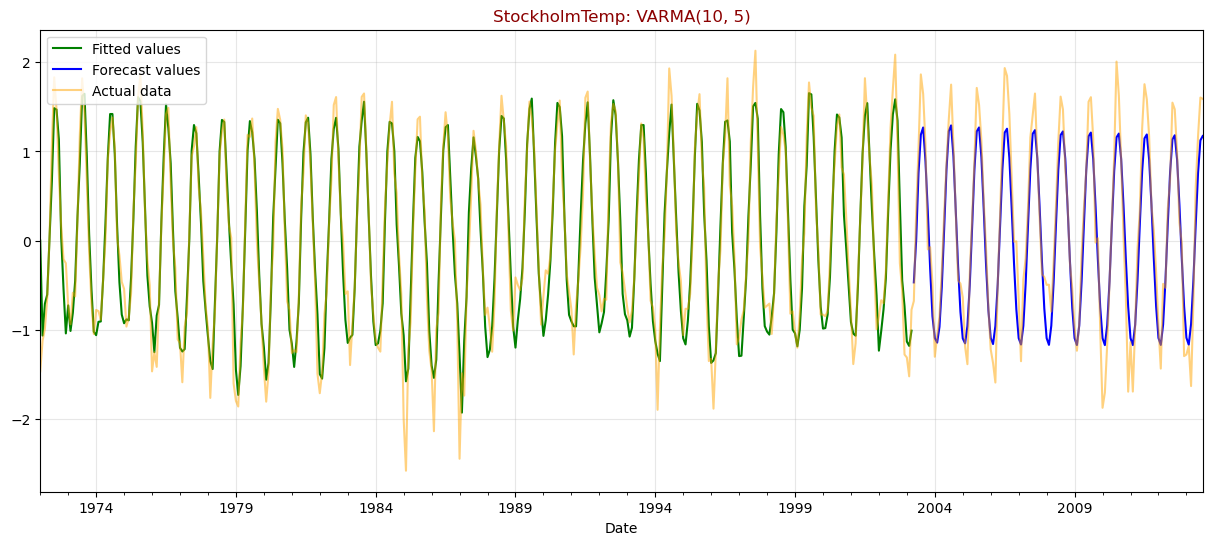

                                   Statespace Model Results                                  
Dep. Variable:     ['AucklandTemp', 'StockholmTemp']   No. Observations:                  375
Model:                                   VARMA(10,5)   Log Likelihood                 -77.420
                                         + intercept   AIC                            284.839
Date:                               Fri, 25 Oct 2024   BIC                            540.090
Time:                                       22:06:10   HQIC                           386.175
Sample:                                   01-01-1972                                         
                                        - 03-01-2003                                         
Covariance Type:                                 opg                                         
Ljung-Box (L1) (Q):             0.05, 0.18   Jarque-Bera (JB):          0.34, 54.75
Prob(Q):                        0.83, 0.67   Prob(JB):                

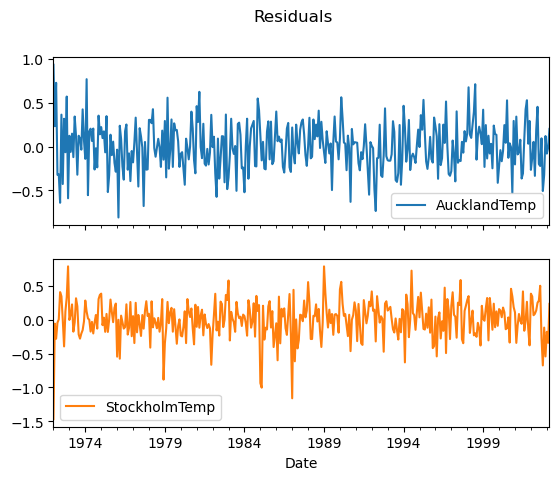

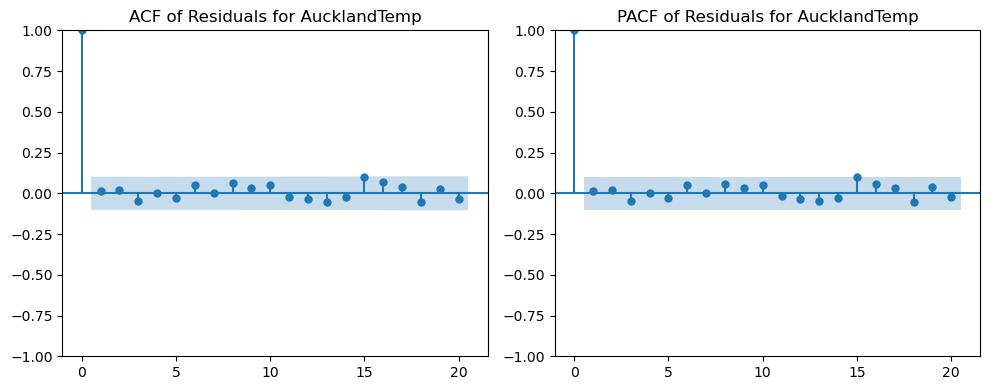

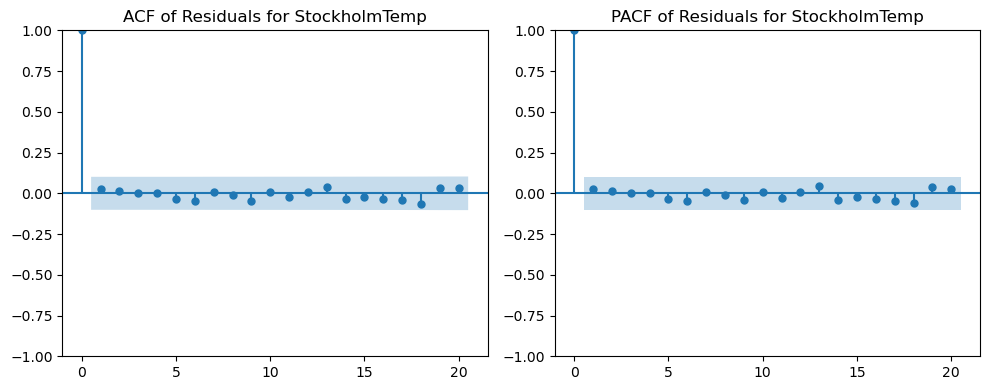

In [30]:
# Run the model, return values for further evaluation, set scaling, set plot, return summary and post diagnostic
# The data is monthly, hence set freq to MS
# The order (10, 5) can be considered arbitrary for illustration

actual_train, train_prediction, actual_test, test_forecast = (
    varma_split(joined_part_a, cols_1, freq='MS', Ntest=125, 
                 order=(10, 5),
                 maxiter=100, use_scaling=True, plot=True,
               summary = True, diagnostic = True) )

* The model passes the Ljung-Box test.
* No signficant autocorrelations among the residuals are observed in their ACF and PACF plots.

In [32]:
# We should also do sanity check for our standard normalization and its reversion
joined_part.head()

,AucklandTemp,StockholmTemp
Date,,
1972-01-01,64.7312,27.9194
1972-02-01,65.2010,31.8020
1972-03-01,67.2116,33.3140
1972-04-01,62.6378,37.1462
1972-05-01,58.4708,44.9906


In [33]:
actual_train[['AucklandTemp', 'StockholmTemp']].head()

,AucklandTemp,StockholmTemp
Date,,
1972-01-01,64.7312,27.9194
1972-02-01,65.2010,31.8020
1972-03-01,67.2116,33.3140
1972-04-01,62.6378,37.1462
1972-05-01,58.4708,44.9906


* OK the back transform works. Let's calculate the performance metrics.

In [35]:
evaluate_varma(actual_train, train_prediction)

,MAE,MSE,RMSE,MAPE,R²
AucklandTemp,1.053603,1.734285,1.316923,1.754637,0.925249
StockholmTemp,2.359189,9.790600,3.128994,6.235311,0.923266


In [36]:
evaluate_varma(actual_test, test_forecast)

,MAE,MSE,RMSE,MAPE,R²
AucklandTemp,1.164086,2.177511,1.475639,1.909973,0.902060
StockholmTemp,3.183860,15.409838,3.925537,7.482496,0.888281


### 3.3. Define optimization function to select the optimal models
* For VAR and VARMA, the BIC criterion is better than AIC. The BIC penalty term increases more rapidly than the AIC penalty as the number of parameters grows, meaning BIC tends to favor simpler models. This is good to deal with model over-fitting.
* <b>There are techniques to select the optimal orders of the VARMA model, including economic theory or optimization approach. It depends on your decision. <b>

### 3.4. The 2nd dataset (Econometric data)
* In normal VAR and VARMA models, all input series are treated as endogeneous variables.
* Economic data are good candidates for VAR and VARMA models owing to the interplays among economic variables.
* In this example, we use Term spreads (differences between long- and short interest rates) and GDP Growth to fit into the VARMA models.

In [39]:
df2 = pd.read_excel('us_macro_quarterly.xlsx')
df2.head(3)

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333


In [40]:
def parse_date(data):
  # quarter is in {01,02,03,04}
  year, quarter = data.split(':')
  month = (int(quarter) - 1) * 3 + 1
  s = f"{year}-{month}"
  return datetime.strptime(s, "%Y-%m")

In [41]:
df2['Date'] = df2['Unnamed: 0'].apply(parse_date)

In [42]:
df2.set_index(df2['Date'], inplace=True)
df2.drop(['Date', 'Unnamed: 0'], axis=1, inplace=True)

In [43]:
df2.head(3)

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333


In [44]:
df2['TSpread'] = df2['GS10'] - df2['TB3MS'] #Term spread = long-term investment (10 years) - short-term invesment (3 months)

In [45]:
cols_2 = ['GDPC96', 'TSpread'] # series interested

In [46]:
check_stationarity(df2[cols_2])

,ADF Test,KPSS Test (Trend),KPSS Test (Constant)
Series,,,
GDPC96,Non-Stationary,Non-Stationary,Non-Stationary
TSpread,Stationary,Stationary,Non-Stationary


In [47]:
difference_until_pass_kpss(df2[cols_2])

Processing 'GDPC96':
'GDPC96' became stationary after 2 differencing(s).


Processing 'TSpread':
'TSpread' became stationary after 1 differencing(s).




* Because they are of different Integration orders, we can try to do log transform for GDPC96 (GDP data) first to see if we can make them to have a same Integration order, which also make senses here.

In [49]:
df2['LogGDP'] =  np.log(df2.GDPC96)

In [50]:
cols_2b = ['LogGDP','TSpread']
difference_until_pass_kpss(df2[cols_2b])

Processing 'LogGDP':
'LogGDP' became stationary after 1 differencing(s).


Processing 'TSpread':
'TSpread' became stationary after 1 differencing(s).




* OK now we can difference both of them once.

In [52]:
df2_diff = df2[cols_2b]
df2_diff = df2_diff.diff().dropna()
df2_diff.head(3)

,LogGDP,TSpread
Date,,
1957-04-01,-0.002220,0.180000
1957-07-01,0.009693,0.086667
1957-10-01,-0.010303,-0.250000


In [53]:
check_stationarity(df2_diff[cols_2b]) # sanity check after differencing

,ADF Test,KPSS Test (Trend),KPSS Test (Constant)
Series,,,
LogGDP,Stationary,Stationary,Stationary
TSpread,Stationary,Stationary,Stationary


In [54]:
Ntest_2 = round(len(df2_diff)*0.2)
Ntest_2

45

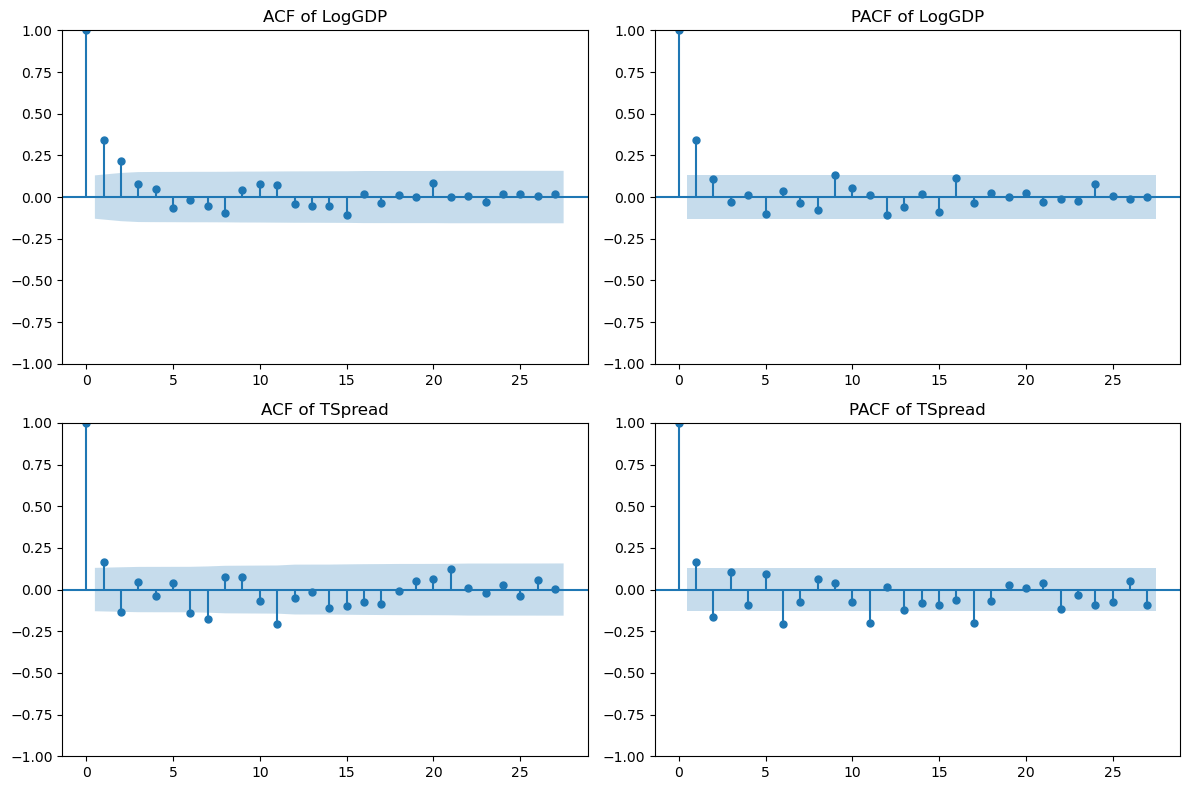

In [55]:
plot_acf_pacf(df2_diff, lags = 27);

In [56]:
# Again create a copy to re-use later
df2_diff_a =  df2_diff.copy()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           97     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.83142D+00    |proj g|=  4.75174D+00

At iterate    5    f= -2.83348D+00    |proj g|=  4.72247D+00

At iterate   10    f= -2.83541D+00    |proj g|=  2.60577D+00

At iterate   15    f= -2.84059D+00    |proj g|=  5.86094D+00

At iterate   20    f= -2.84653D+00    |proj g|=  3.18543D+00

At iterate   25    f= -2.85682D+00    |proj g|=  1.18180D+00

At iterate   30    f= -2.85728D+00    |proj g|=  8.38210D-01

At iterate   35    f= -2.85952D+00    |proj g|=  1.61850D+00

At iterate   40    f= -2.86158D+00    |proj g|=  2.32159D+00

At iterate   45    f= -2.86440D+00    |proj g|=  1.17490D+00

At iterate   50    f= -2.86873D+00    |proj g|=  7.41449D-01

At iterate   55    f= -2.87088D+00    |proj g|=  1.17838D+00

At iterate   60    f= -2.87185D+00    |proj g|=  2.76581D-01

At iterate   65    f= -2.8

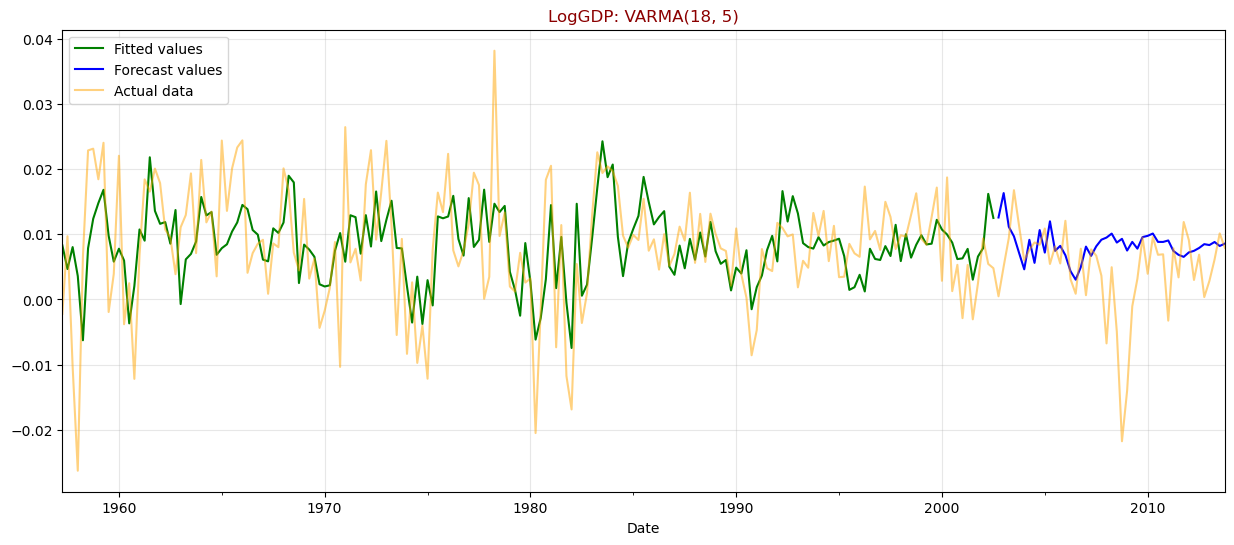

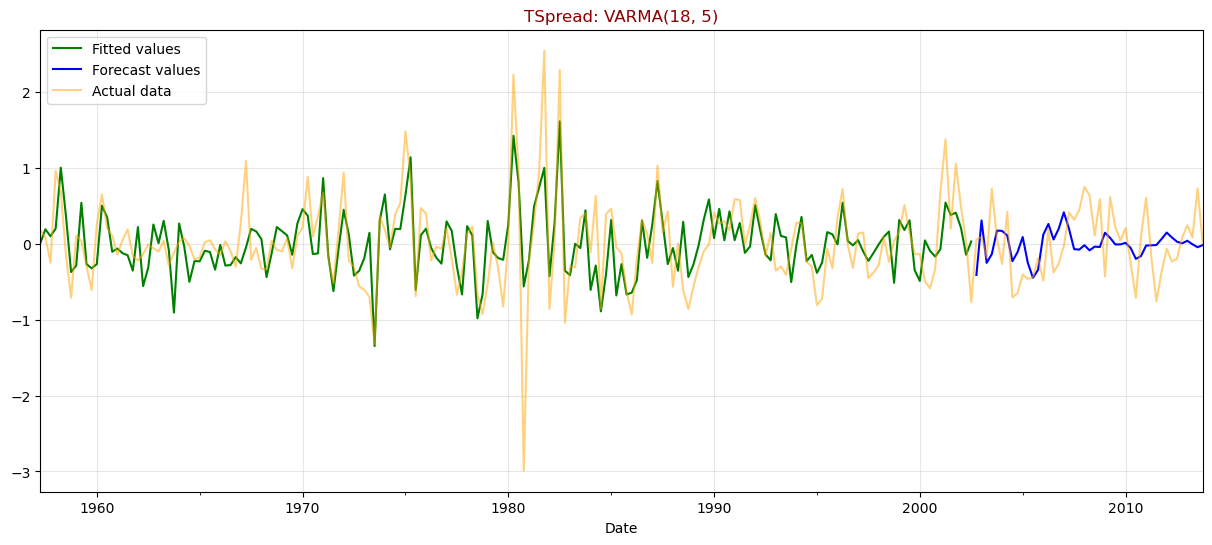

                             Statespace Model Results                            
Dep. Variable:     ['LogGDP', 'TSpread']   No. Observations:                  182
Model:                       VARMA(18,5)   Log Likelihood                 523.928
                             + intercept   AIC                           -853.856
Date:                   Fri, 25 Oct 2024   BIC                           -543.067
Time:                           22:07:29   HQIC                          -727.866
Sample:                       04-01-1957                                         
                            - 07-01-2002                                         
Covariance Type:                     opg                                         
Ljung-Box (L1) (Q):             0.12, 0.00   Jarque-Bera (JB):         2.10, 124.53
Prob(Q):                        0.73, 0.97   Prob(JB):                   0.35, 0.00
Heteroskedasticity (H):         0.36, 1.66   Skew:                     -0.03, -0.57
Prob(H) (t

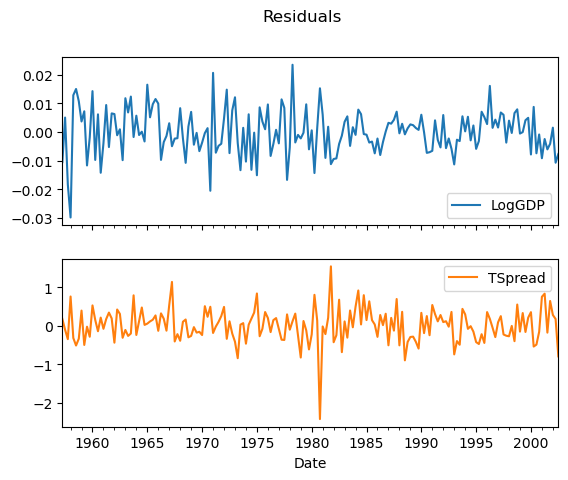

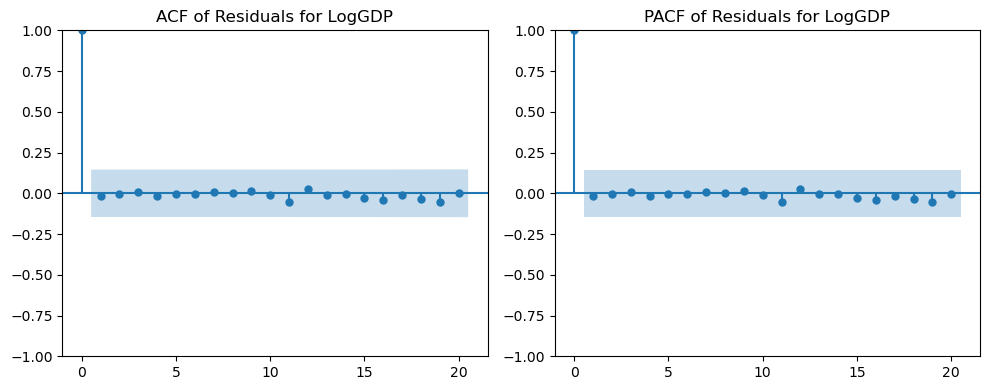

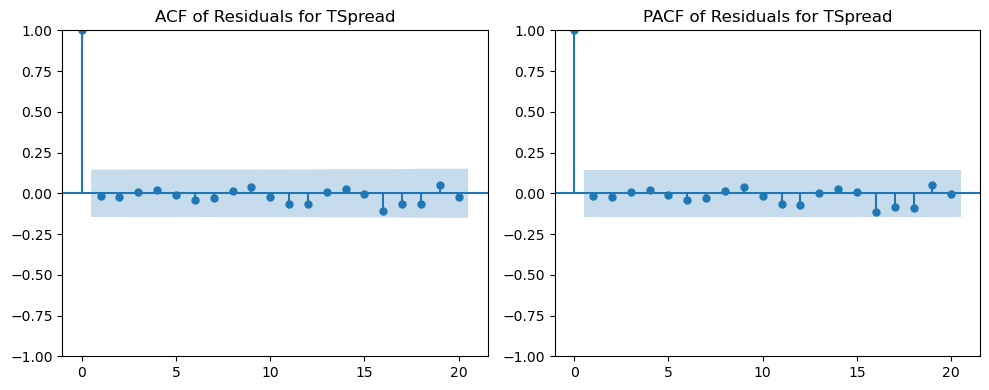

In [57]:
actual_train2, train_prediction2, actual_test2, test_forecast2 = (
    varma_split(df2_diff_a, cols_2b, Ntest = 45 , freq = 'QS',
                order = (18, 5), maxiter = 100, 
                use_scaling = False, plot = True, summary = True, diagnostic = True)
) # quarterly data -> QS

In [58]:
evaluate_varma(actual_train2, train_prediction2)

,MAE,MSE,RMSE,MAPE,R²
LogGDP,0.006078,0.000061,0.007830,186.180814,0.277750
TSpread,0.329050,0.189023,0.434767,274.978921,0.467291


In [59]:
evaluate_varma(actual_test2, test_forecast2)

,MAE,MSE,RMSE,MAPE,R²
LogGDP,0.005448,0.000065,0.008090,227.996226,-0.461884
TSpread,0.360140,0.182634,0.427358,164.347705,-0.067330


## <b>3. VAR<b>

### 3.1. Define VAR function

* The major differences compared to defining VARMA function above is that we do not have to select the orders, rather we choose the criterion for model selection, and then we can have the optimal model based on that.
* We preferred BIC over AIC for VAR models.

* The workflow for the VAR models:
1. Set the input parameters dynamically, including the model selection criterion (BIC)
2. Set the frequency for the time series data
3. Split the dataset into training and testing sets (after differencing)
4. Normalization if needed
5. Fit the VARMA model on the differenced and scaled training data.
6. Select the optimal model based on BIC
7. Forecast the test data
8. Revert scaling if needed
9. Plot the graph if needed
10. Return trained and forecasted data to calculate performance metrics later
11. Run summary and post model diagnostics. Note that built-in summary result does not have the Ljung-Box and JB test, hence we also need to add.

In [62]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera

def var_split(df, cols, freq='QS', Ntest=12, 
              maxlags=20, ic='bic', 
              use_scaling=False, plot=True, summary=True, diagnostics=True):
    """
    Dynamic VAR modeling for any time series dataset with optional scaling, summary, diagnostics, and plotting.
    
    Parameters:
    df: pandas.DataFrame - The input DataFrame with time series data.
    cols: list - List of column names to use in the VAR model.
    freq: str - Frequency of the time series data ('QS' for Quarterly Start by default).
    Ntest: int - Number of test samples for forecasting.
    maxlags: int - Maximum number of lags to consider for model fitting.
    ic: str - Information criterion to select lags ('bic', 'aic', etc.).
    use_scaling: bool - Whether to scale the data (default is False).
    plot: bool - Whether to plot the actual and predicted values (default is True).
    summary: bool - Whether to print the model summary (default is True).
    diagnostics: bool - Whether to print residual diagnostics like ACF, PACF, Ljung-Box, and Jarque-Bera tests (default is True).
    
    Returns:
    actual_train: The actual values for the training period (for all columns).
    train_prediction: The predicted values for the training period (for all columns).
    actual_test: The actual values for the testing period (for all columns).
    test_forecast: The predicted values for the testing period (for all columns).
    """
    # Set the frequency for the time series data
    df.index.freq = freq
    
    # Split the dataset into training and testing sets
    train = df.iloc[:-Ntest].copy()
    test = df.iloc[-Ntest:].copy()
    
    # Boolean indexing for train and test
    train_idx = df.index <= train.index[-1]
    test_idx = ~train_idx
    
    # Initialize scaler if scaling is enabled
    if use_scaling:
        scaler = StandardScaler()
        train[cols] = scaler.fit_transform(train[cols])
        test[cols] = scaler.transform(test[cols])
        
        # Put the scaled values back into the original DataFrame
        df.loc[train_idx, cols] = train[cols]
        df.loc[test_idx, cols] = test[cols]
    
    # Fit the VAR model on the training data
    model = VAR(train[cols])
    
    # Select the optimal number of lags
    lag_order_results = model.select_order(maxlags=maxlags)
    selected_lag = lag_order_results.selected_orders[ic]  # by default use BIC for lag selection
    
    # Fit the model with the selected number of lags
    results = model.fit(selected_lag)
    lag_order = results.k_ar
    
    # 'prior' contains the lag_order rows of data needed for forecasting
    prior = train.iloc[-lag_order:][cols].to_numpy()

    # Forecast for the next Ntest points
    fcast = results.forecast(prior, Ntest)

    # Store the actual and predicted values for all columns
    actual_train_scaled = df.loc[train_idx, cols].values
    train_prediction_scaled = results.fittedvalues[cols].values
    actual_test_scaled = df.loc[test_idx, cols].values
    test_forecast_scaled = fcast
    
    # Adjust the indices for the fitted values to account for the lag period
    fitted_index = df.loc[train_idx].index[lag_order:]  # Exclude the first lag_order observations
    
    # Reverting transformation back to the original scale if scaling was applied
    if use_scaling:
        actual_train = pd.DataFrame(scaler.inverse_transform(actual_train_scaled), columns=cols, index=df.loc[train_idx].index)
        train_prediction = pd.DataFrame(scaler.inverse_transform(train_prediction_scaled), columns=cols, index=fitted_index)
        actual_test = pd.DataFrame(scaler.inverse_transform(actual_test_scaled), columns=cols, index=df.loc[test_idx].index)
        test_forecast = pd.DataFrame(scaler.inverse_transform(test_forecast_scaled), columns=cols, index=df.loc[test_idx].index)
    else:
        actual_train = pd.DataFrame(actual_train_scaled, columns=cols, index=df.loc[train_idx].index)
        train_prediction = pd.DataFrame(train_prediction_scaled, columns=cols, index=fitted_index)
        actual_test = pd.DataFrame(actual_test_scaled, columns=cols, index=df.loc[test_idx].index)
        test_forecast = pd.DataFrame(test_forecast_scaled, columns=cols, index=df.loc[test_idx].index)

    # Plot actual vs predicted values for each column dynamically
    if plot:
        for i, col in enumerate(cols):
            plt.figure(figsize=(15, 6))
            
            # Plot fitted and forecasted values
            df.loc[fitted_index, f'Train Pred {col}'] = results.fittedvalues[col]
            df.loc[test_idx, f'Test Pred {col}'] = fcast[:, i]

            df.loc[fitted_index, f'Train Pred {col}'].plot(color='green', label=f'Train Pred {col}')
            df.loc[test_idx, f'Test Pred {col}'].plot(color='blue', label=f'Test Pred {col}')
        
            # Plot actual data for this column only
            df[col].plot(color='orange', label=f'Actual {col}', alpha=0.5)
        
            plt.title(f"{col}: Actual vs Predicted (VAR with {selected_lag} lags)", color='darkred')
            plt.grid(True, alpha=0.3)
            plt.legend(loc='upper left')
            plt.show()
    
    # Print model summary if required
    if summary:
        print(results.summary())
    
    # Diagnostic plots and tests
    if diagnostics:
        residuals = results.resid
        
        # Plot residuals for each variable
        residuals.plot(subplots=True, title='Residuals')
        plt.show()
        
        # Ljung-Box Test for autocorrelation in residuals
        print("Ljung-Box Test Results:")
        for i, col in enumerate(cols):
            ljung_box_result = acorr_ljungbox(residuals.iloc[:, i], lags=[10], return_df=True)  # Use iloc for column access
            print(f"{col}:")
            print(ljung_box_result)
        
        # Jarque-Bera Test for normality of residuals
        print("Jarque-Bera Test Results:")
        for i, col in enumerate(cols):
            jb_stat, jb_pvalue = jarque_bera(residuals.iloc[:, i])  # Use iloc for column access
            print(f"{col}: JB Stat = {jb_stat:.4f}, p-value = {jb_pvalue:.4f}")
        
        # Plot ACF and PACF for residuals
        for i, col in enumerate(cols):
            plt.figure(figsize=(12, 5))
            plt.subplot(121)
            plot_acf(residuals.iloc[:, i], lags=20, ax=plt.gca())  # Use iloc for column access
            plt.title(f"ACF of Residuals for {col}")
            plt.subplot(122)
            plot_pacf(residuals.iloc[:, i], lags=20, ax=plt.gca())  # Use iloc for column access
            plt.title(f"PACF of Residuals for {col}")
            plt.tight_layout()
            plt.show()

    return actual_train, train_prediction, actual_test, test_forecast

### 3.2. Define a specific evaluation function for VAR models
* We can still extend the `evaluate_varma` but for me, it is better to separate them to maintain consistency.

In [64]:
def evaluate_var(y_true, y_pred, p, logged_cols=None):
    """
    Evaluate common metrics for a VAR model, handling cases where some series are log-transformed.
    
    Args:
        y_true: A pandas DataFrame or a 1D/2D array of actual values.
        y_pred: A pandas DataFrame or a 1D/2D array of predicted values.
        p: Integer, the autoregressive lag (number of lags used in the VAR model).
        logged_cols: List of column names (for DataFrame) or indices (for arrays) that are log-transformed.
                     If evaluating a single series, pass a boolean indicating if the series is logged.
    
    Returns:
        A pandas DataFrame with evaluation metrics (MAE, MSE, RMSE, MAPE, R²).
    """
    # Discard the first 'p' observations in y_true to match y_pred
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.iloc[p:]
    elif isinstance(y_true, pd.Series):
        y_true = y_true.iloc[p:]
    elif isinstance(y_true, np.ndarray):
        y_true = y_true[p:]

    # Ensure that y_true and y_pred have the same index or length
    if isinstance(y_true, pd.DataFrame) and isinstance(y_pred, pd.DataFrame):
        # Align both DataFrames to ensure same index (dates, time steps)
        y_true, y_pred = y_true.align(y_pred, join='inner')

    # If still not the same length, raise an error
    if len(y_true) != len(y_pred):
        raise ValueError(f"y_true and y_pred have different lengths after adjustment: {len(y_true)} and {len(y_pred)}")

    # Check if it's a univariate case (1D array or a pandas Series)
    if isinstance(y_true, (pd.Series, np.ndarray)) and y_true.ndim == 1:
        # If logged_cols is a boolean and True, apply exp transformation
        if isinstance(logged_cols, bool) and logged_cols:
            y_true = np.exp(y_true)
            y_pred = np.exp(y_pred)
        
        # Calculate metrics for the single series
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.inf
        r2 = r2_score(y_true, y_pred)
        
        metrics = {
            'MAE': round(mae, 6),
            'MSE': round(mse, 6),
            'RMSE': round(rmse, 6),
            'MAPE': round(mape, 6) if not np.isinf(mape) else np.nan,
            'R²': round(r2, 6)
        }
        
        # Convert the result to a DataFrame with a single row
        return pd.DataFrame([metrics], index=['Univariate'])

    else:
        # If logged_cols is None, assume no logging; otherwise, handle list of log-transformed columns
        logged_cols = logged_cols if logged_cols is not None else []
        
        # Convert to DataFrame if numpy array is provided
        if isinstance(y_true, np.ndarray):
            y_true = pd.DataFrame(y_true)
        if isinstance(y_pred, np.ndarray):
            y_pred = pd.DataFrame(y_pred)
        
        # Loop through each variable (column) and calculate metrics individually
        metrics = {}
        for col in y_true.columns:
            actual = y_true[col]
            predicted = y_pred[col]
            
            # If the column is logged, revert it back to the original scale
            if col in logged_cols:
                actual = np.exp(actual)
                predicted = np.exp(predicted)
            
            # Calculate evaluation metrics
            mae = mean_absolute_error(actual, predicted)
            mse = mean_squared_error(actual, predicted)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual - predicted) / actual)) * 100 if np.all(actual != 0) else np.inf
            r2 = r2_score(actual, predicted)
            
            # Store metrics for the current variable
            metrics[col] = {
                'MAE': round(mae, 6),
                'MSE': round(mse, 6),
                'RMSE': round(rmse, 6),
                'MAPE': round(mape, 6) if not np.isinf(mape) else np.nan,
                'R²': round(r2, 6)
            }
    
        # Convert the dictionary to a DataFrame
        metrics_df = pd.DataFrame(metrics).T  # Transpose to have variables as rows
        return metrics_df

### 3.3. Running VAR with the 1st dataset above

In [66]:
joined_part_b = joined_part.copy()
joined_part_b.head(3)

,AucklandTemp,StockholmTemp
Date,,
1972-01-01,64.7312,27.9194
1972-02-01,65.2010,31.8020
1972-03-01,67.2116,33.3140


In [67]:
cols_1

['AucklandTemp', 'StockholmTemp']

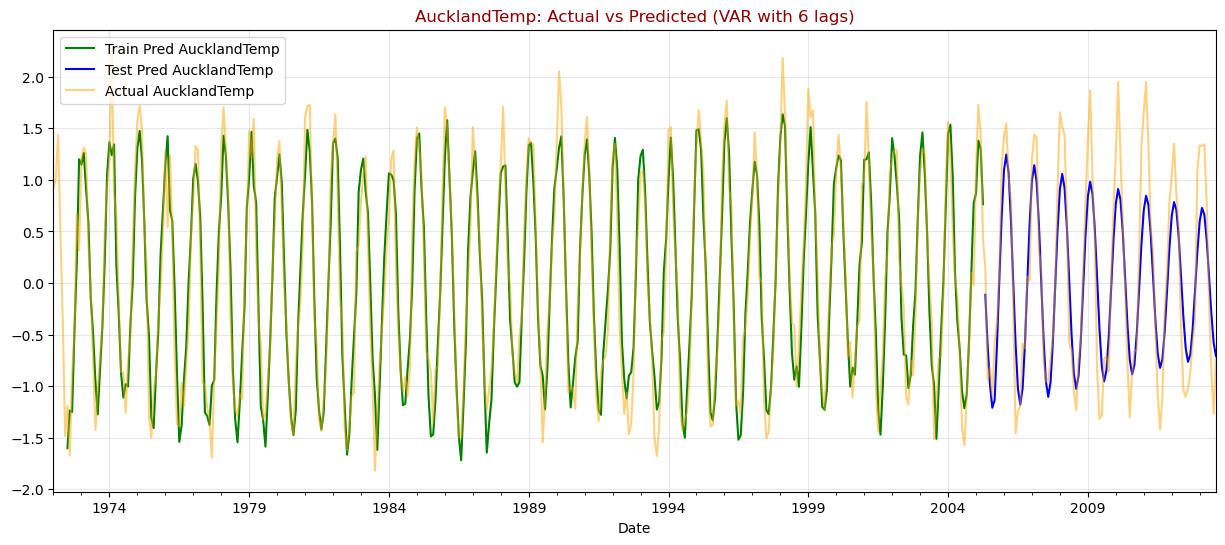

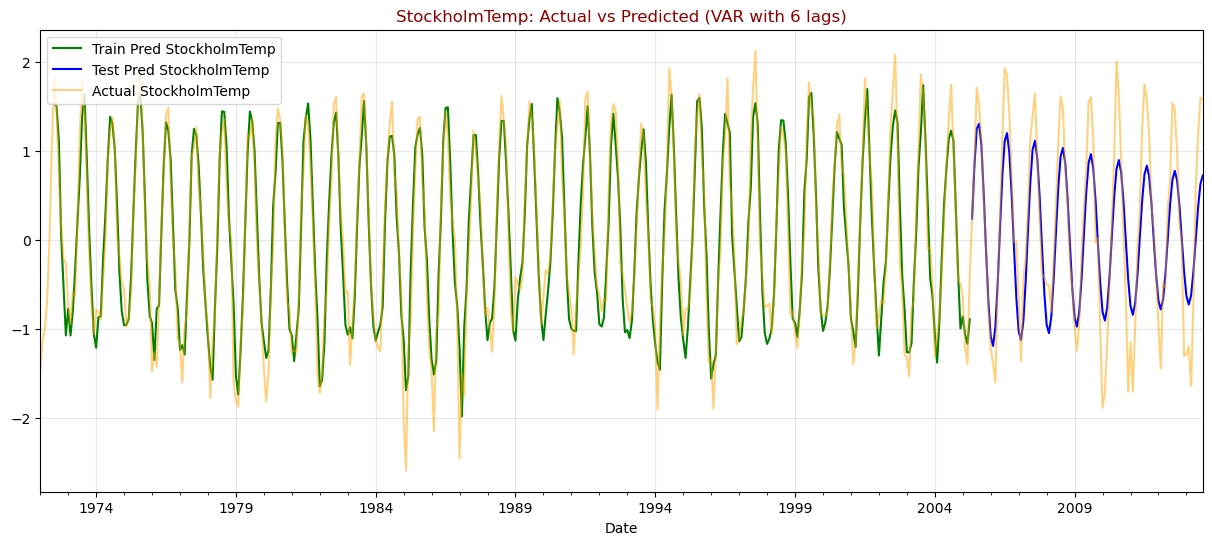

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 25, Oct, 2024
Time:                     22:07:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.47820
Nobs:                     394.000    HQIC:                  -4.63662
Log likelihood:          -158.226    FPE:                 0.00873385
AIC:                     -4.74060    Det(Omega_mle):      0.00818482
--------------------------------------------------------------------
Results for equation AucklandTemp
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.008745         0.015727           -0.556           0.578
L1.AucklandTemp          0.544332         0.049544           10.987           0.000
L1.StockholmTemp         0.063913        

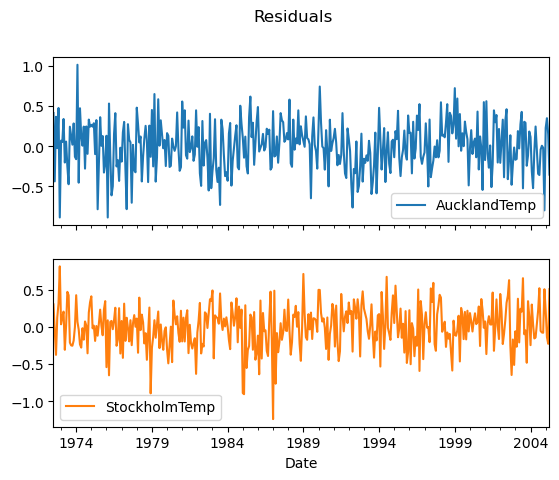

Ljung-Box Test Results:
AucklandTemp:
      lb_stat  lb_pvalue
10  26.472437   0.003154
StockholmTemp:
      lb_stat  lb_pvalue
10  10.512988   0.396696
Jarque-Bera Test Results:
AucklandTemp: JB Stat = 1.6475, p-value = 0.4388
StockholmTemp: JB Stat = 18.2385, p-value = 0.0001


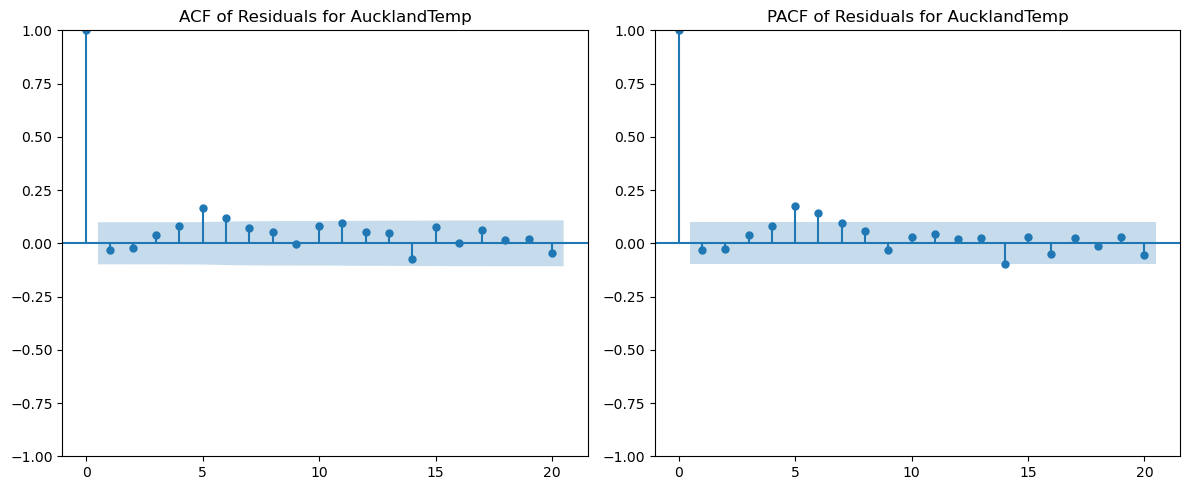

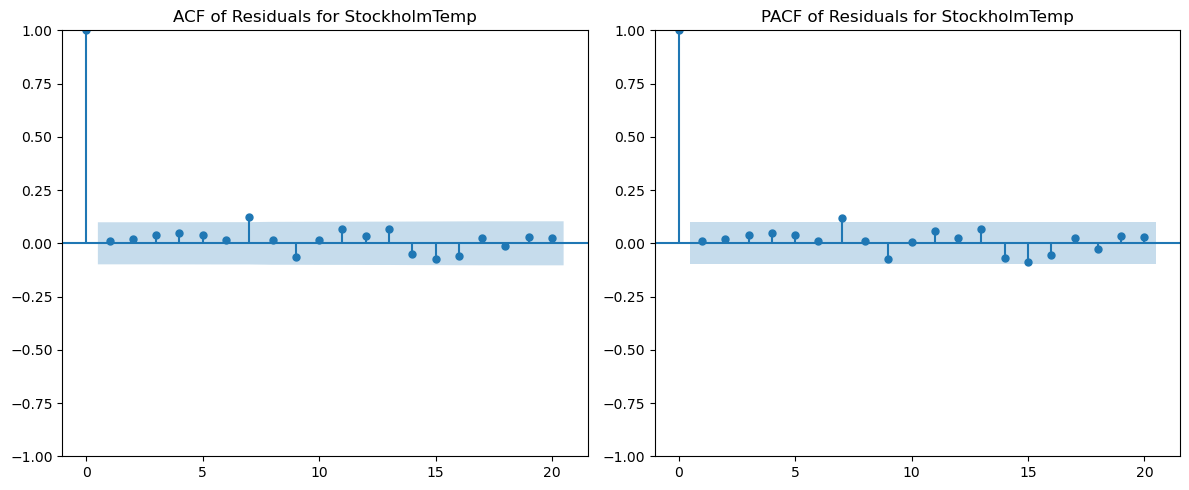

In [68]:
actual_train3, train_prediction3, actual_test3, test_forecast3 = (
    var_split(joined_part_b, cols_1, freq='MS', 
              Ntest=100, maxlags=20, ic='bic', 
              use_scaling=True, plot=True,
             summary=True, diagnostics=True)
)

In [69]:
evaluate_var(actual_train3, train_prediction3, p = 6)

,MAE,MSE,RMSE,MAPE,R²
AucklandTemp,1.183859,2.170053,1.473110,1.976118,0.905873
StockholmTemp,2.561263,10.619352,3.258735,6.575800,0.916589


* The model uses p previous observations to predict the next values. As a result, the first p (6) observations of the train data are used as "initialization" and are not predicted by the model

In [71]:
evaluate_var(actual_test3, test_forecast3, p = 0)

,MAE,MSE,RMSE,MAPE,R²
AucklandTemp,1.672137,4.399494,2.097497,2.731940,0.803800
StockholmTemp,4.482371,31.647797,5.625637,10.649661,0.776585


* Compared to the VARMA approach:
1. One series does not pass the Ljung-Box test, implying autocorrelation among the residuals. If the best model suggested by the machine can’t pass this test, then we need to find another model.
2. The performance metrics are lower.

### 3.4. Running VAR with the 2nd dataset above

In [74]:
df2_diff_b = df2_diff.copy()
df2_diff_b.head(3)

,LogGDP,TSpread
Date,,
1957-04-01,-0.002220,0.180000
1957-07-01,0.009693,0.086667
1957-10-01,-0.010303,-0.250000


In [75]:
cols_2b

['LogGDP', 'TSpread']

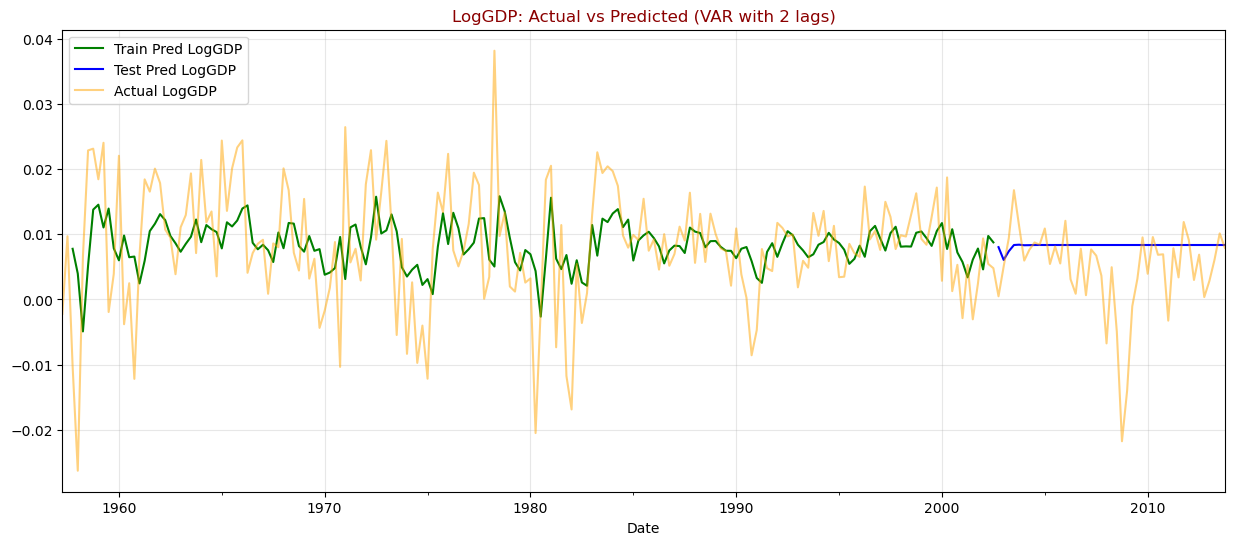

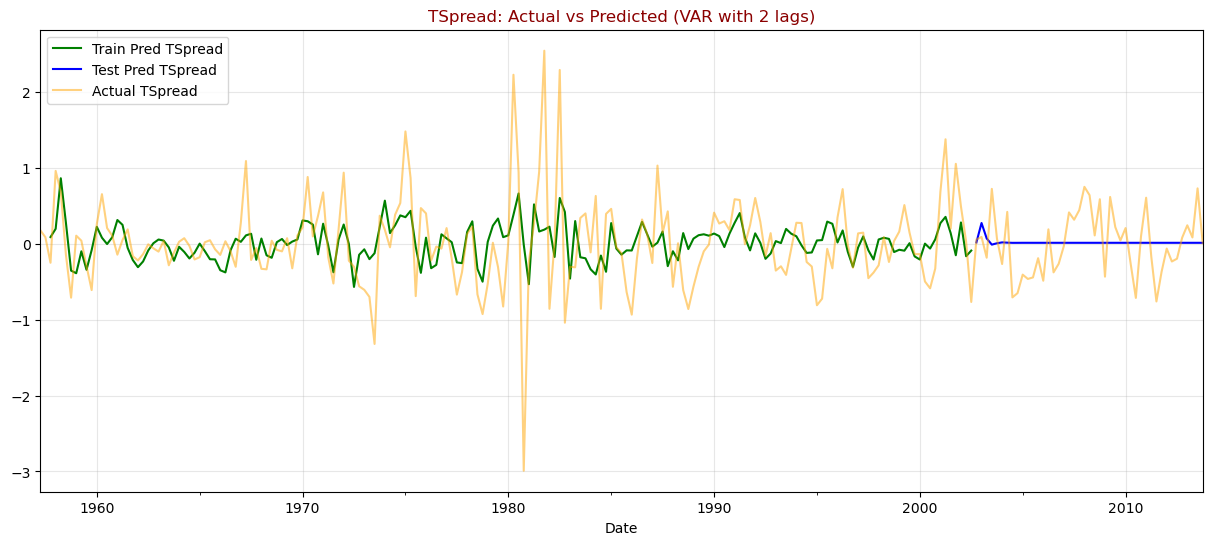

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 25, Oct, 2024
Time:                     22:07:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.4275
Nobs:                     180.000    HQIC:                  -10.5329
Log likelihood:           453.618    FPE:                2.47964e-05
AIC:                     -10.6048    Det(Omega_mle):     2.34742e-05
--------------------------------------------------------------------
Results for equation LogGDP
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.005106         0.001037            4.924           0.000
L1.LogGDP          0.269724         0.076022            3.548           0.000
L1.TSpread        -0.001196         0.001160           -1.031          

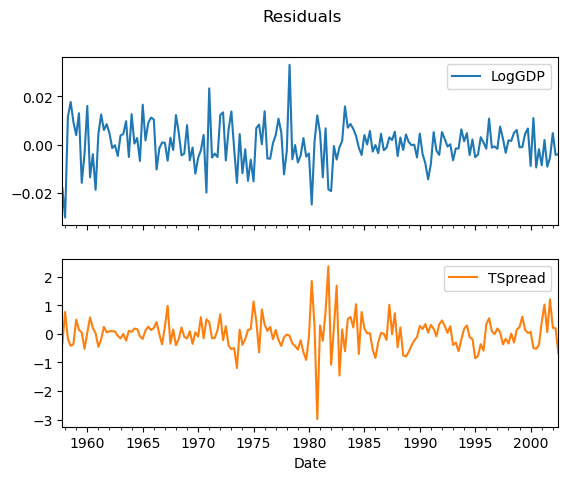

Ljung-Box Test Results:
LogGDP:
     lb_stat  lb_pvalue
10  7.198818   0.706552
TSpread:
      lb_stat  lb_pvalue
10  15.110092   0.128099
Jarque-Bera Test Results:
LogGDP: JB Stat = 17.9718, p-value = 0.0001
TSpread: JB Stat = 288.3060, p-value = 0.0000


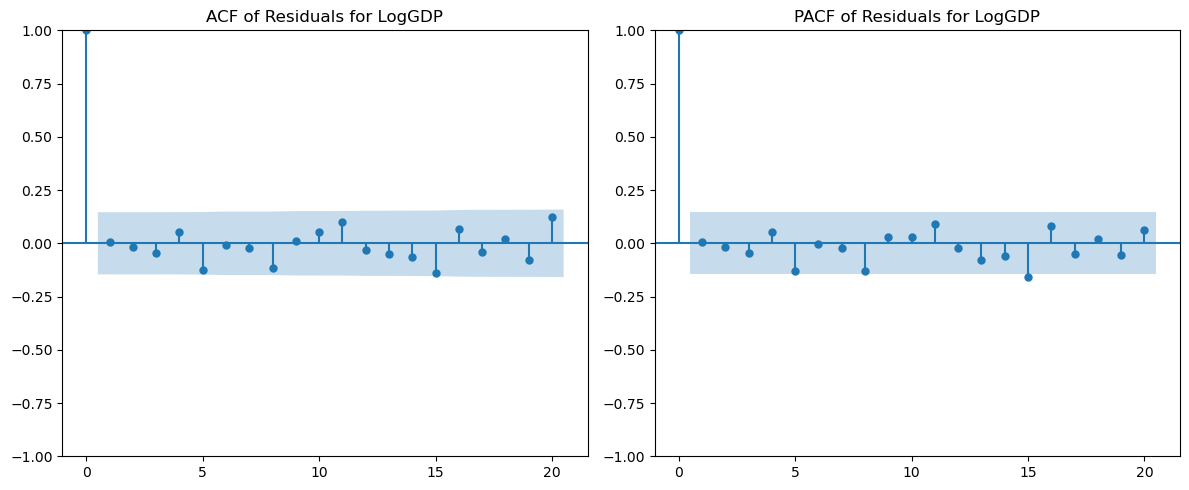

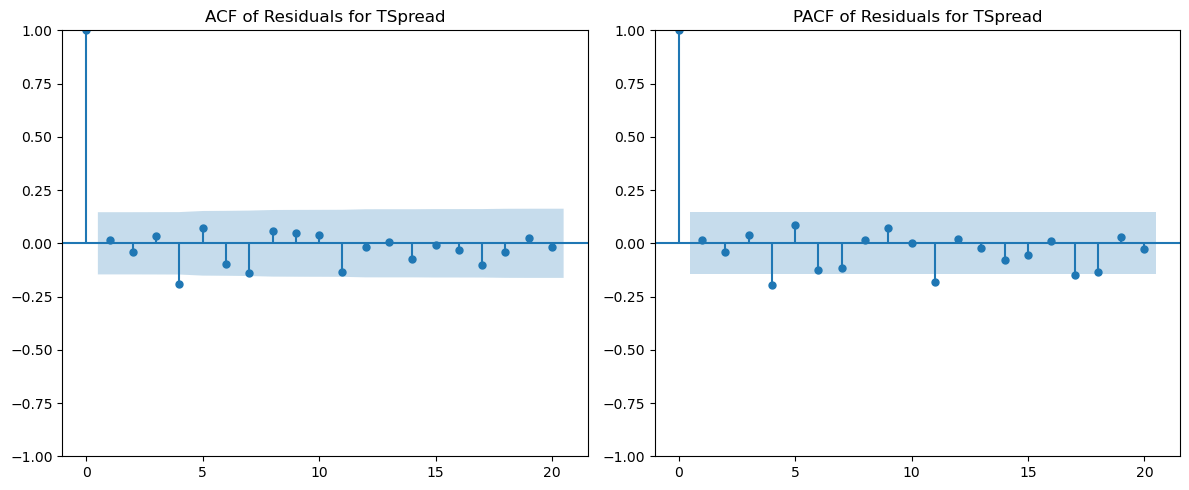

In [76]:
# quarterly data -> QS; also note to adjust Ntest due to the operations of VAR compared to VARMA
actual_train4, train_prediction4, actual_test4, test_forecast4 = (
    var_split(df2_diff_b, cols_2b, freq='QS', 
              Ntest=45, maxlags=20, ic='bic', 
              use_scaling=False, plot=True,
             summary=True, diagnostics=True)
)

In [77]:
evaluate_var(actual_train4, train_prediction4, p = 2)

,MAE,MSE,RMSE,MAPE,R²
LogGDP,0.006471,0.000075,0.008641,172.183442,0.123672
TSpread,0.379156,0.304661,0.551961,183.605445,0.150386


In [78]:
evaluate_var(actual_test4, test_forecast4, p = 0)

,MAE,MSE,RMSE,MAPE,R²
LogGDP,0.004893,0.000058,0.007632,212.464719,-0.301187
TSpread,0.346214,0.173225,0.416203,102.089561,-0.012342


## <b>4. VAR vs VARMA<b>

In choosing a model order of for a VARMA model, we are incorporating both autoregressive (AR) and moving average (MA) terms, while a VAR model only uses autoregressive terms. This additional flexibility can lead to improved performance, and here's why a VARMA model might outperform an automatically chosen VAR model order:

1. <b>Capturing complex dependencies with Moving Average terms<b>
* VAR models capture dependencies between time series variables by regressing each variable on lagged values of itself and other variables (only AR terms). However, real-world time series data often have short-term shocks or noise that persist across time steps, which is something MA terms are specifically designed to capture.
* VARMA models allow for both AR and MA terms, so a VARMA model can leverage the long-term patterns and also capture the short-term shock or error structures. For example in the first dataset we capture 18 MA lags and 5 AR lags in the VARMA model, whereas the VAR model can only capture the 18 MA lags. This dual approach often allows the VARMA model to fit better and generalize more accurately when complex dependencies are present.

2. <b>Flexibility in handling residual dependencies<b>
* VARMA models often handle residual dependencies more effectively because they can model error terms through the MA component. By accounting for both AR and MA terms, a VARMA model can potentially produce residuals that are closer to white noise (uncorrelated), leading to better predictions. In contrast, a VAR model may leave autocorrelation in the residuals if MA terms are needed but unavailable.

3. <b>High-order AR terms in VAR versus combined AR and MA in VARMA<b>
* VAR models may require very high AR orders to capture both short- and long-term dependencies if no MA terms are available. High-order AR models can become complex and prone to overfitting, especially in the presence of smaller datasets.
* VARMA models can achieve the same or better fit with a lower overall model complexity by incorporating MA terms along with the AR terms. For example by selecting (18,2), we are allowing the model to capture complex behavior without needing excessive AR terms alone, potentially improving generalizability.

4. A VAR model is preferred when simplicity, stability, and interpretability are prioritized, especially if there's no strong evidence for an MA structure in the multivariate time series. However, if the data clearly indicate both AR and MA structures, and we have enough data and computational resources, a VARMA model could potentially yield better accuracy by capturing more complex dynamics.